In [2]:
import os
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [20]:
model1 = ap.models.AstroPhot_Model(
    name = "model1", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    parameters = {"center": [25,25], "q": 0.9, "PA": 322*np.pi/180, "n": 2, "Re": 3, "Ie": 1}, # here we set initial values for each parameter
    target = ap.image.Target_Image(data = np.zeros((100,100)), zeropoint = 27, pixelscale = 1), # every model needs a target, more on this later
)
model1.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

# We can print the model's current state
model1.parameters

model1 (id-140301072545056, branch node):
  center (id-140301069859040): [25.0, 25.0] +- 0.1 [arcsec]
  q (id-140301069858560): 0.9 +- 0.03 [b/a], limits: (0.0, 1.0)
  PA (id-140301071713568): 2.4783675378319474 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
  n (id-140301067744112): 2.0 +- 0.05 [none], limits: (0.36, 8.0)
  Re (id-140301067743968): 3.0 [arcsec], limits: (0.0, None)
  Ie (id-140301067744880): 1.0 [log10(flux/arcsec^2)]

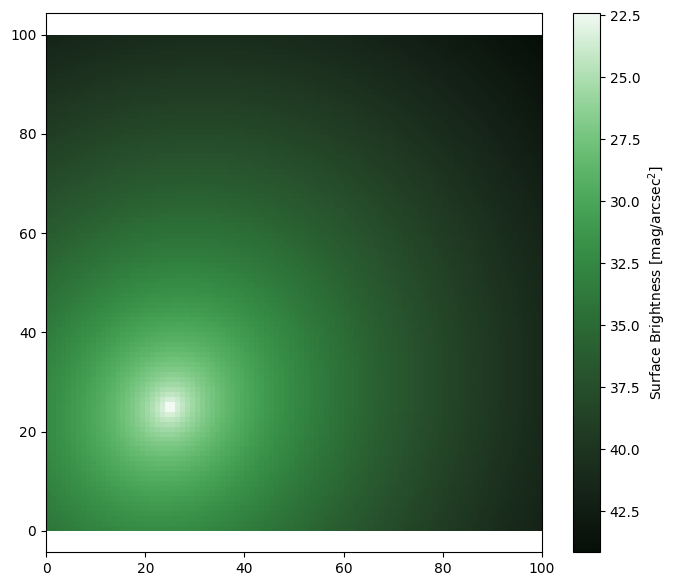

In [21]:
fig, ax = plt.subplots(figsize = (8,7))
ap.plots.model_image(fig, ax, model1)
plt.show()

In [7]:
OII_nebula = fits.getdata('../../output/nebula_fits/OII_nebula.fits')
OIII_nebula = fits.getdata('../../output/nebula_fits/OIII_nebula.fits')
OII_nebula_mask = fits.getdata('../../output/nebula_fits/OII_nebula_mask.fits')
OIII_nebula_mask = fits.getdata('../../output/nebula_fits/OIII_nebula_mask.fits')

# OII nebula

In [26]:
OII_nebula = np.asarray(OII_nebula, dtype=np.float64)

In [27]:
target = ap.image.Target_Image(
    data = OII_nebula,
    pixelscale = 0.168, # Every target image needs to know it's pixelscale in arcsec/pixel
    zeropoint = 27, # optionally, you can give a zeropoint to tell AstroPhot what the pixel flux units are
    variance = np.ones(OII_nebula.shape)/1e3, # set the variance for this image (in general it should be more accurate than this)
)

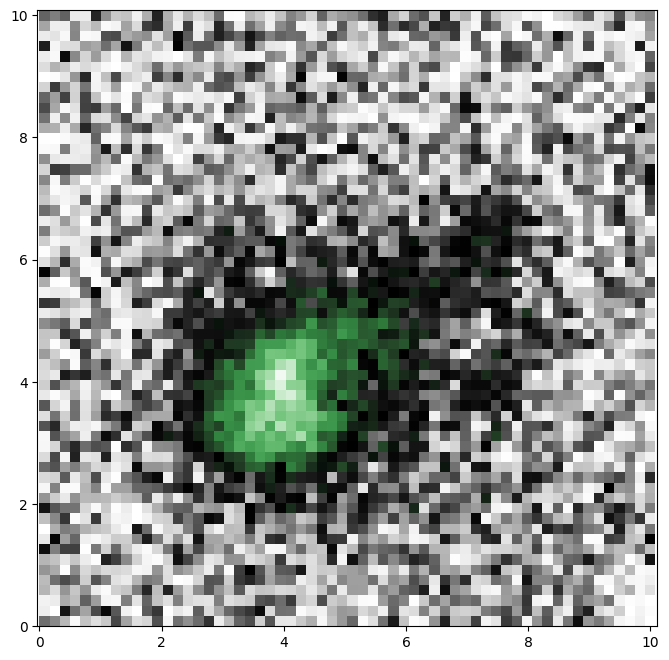

In [28]:
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target)
plt.show()

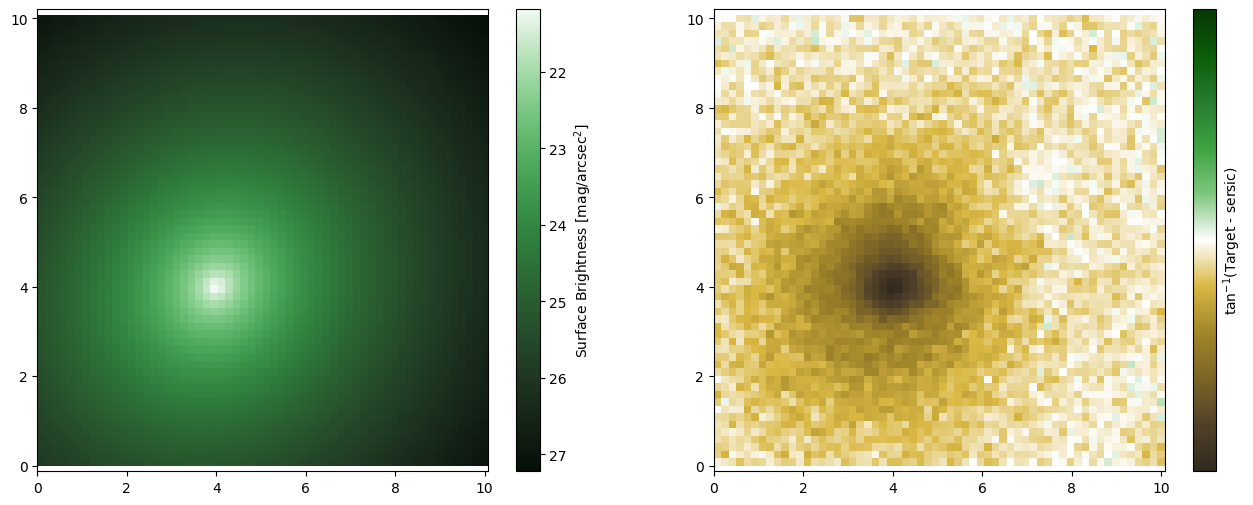

In [36]:
psf_OII = ap.image.PSF_Image(data=fits.getdata('../../output/psf_for_pypher/SUBARU_NB0718_PSFEx_psf.fits').astype(np.float64), pixelscale = 0.168)
model2 = ap.models.AstroPhot_Model(
    name = "sersic", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    parameters = {"center": [4,4], "q": 0.9, "PA": 322*np.pi/180, "n": 2, "Re": 3, "Ie": 1}, # here we set initial values for each parameter
    target = target, # every model needs a target, more on this later
    psf = psf_OII,
)
model2.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

fig4, ax4 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig4, ax4[0], model2)
ap.plots.residual_image(fig4, ax4[1], model2)
plt.show()

In [37]:
# Now that the model has been set up with a target and initialized with parameter values, it is time to fit the image
result = ap.fit.LM(model2, verbose = 1).fit()

# See that we use ap.fit.LM, this is the Levenberg-Marquardt Chi^2 minimization method, it is the recommended technique
# for most least-squares problems. However, there are situations in which different optimizers may be more desireable
# so the ap.fit package includes a few options to pick from. The various fitting methods will be described in a
# different tutorial.
print("Fit message:",result.message) # the fitter will return a message about its convergence

Chi^2: 157.3573590289539, L: 1.0


Chi^2: 16.706351237764743, L: 0.3333333333333333
Chi^2: 7.990164782622366, L: 0.1111111111111111
Chi^2: 6.479421744166009, L: 0.037037037037037035
Chi^2: 6.154131449647415, L: 0.012345679012345678
Chi^2: 5.962098535528338, L: 1.693508780843029e-05
Chi^2: 5.951874466691295, L: 2.323057312541878e-08
Chi^2: 5.950704722545004, L: 7.743524375139593e-09
Chi^2: 5.950541178658525, L: 2.581174791713198e-09
Chi^2: 5.950517741441411, L: 1e-09
Final Chi^2: 5.950514357587061, L: 1e-09. Converged: success
Fit message: success


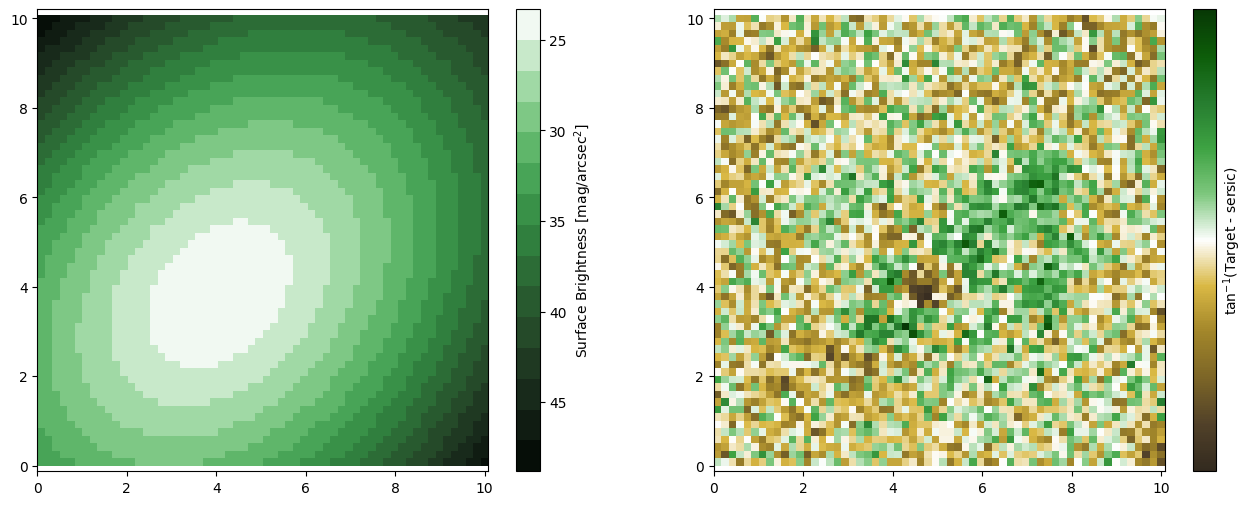

In [46]:
# we now plot the fitted model and the image residuals
fig5, ax5 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig5, ax5[0], model2,cmap_levels=15)
ap.plots.residual_image(fig5, ax5[1], model2)
plt.show()

In [39]:
result.update_uncertainty()
print(model2)

sersic:
center: [4.071415725908137, 3.8451563462062603] +- 0.1 [arcsec]
q: 0.7268556852800545 +- 0.03 [b/a], limits: (0.0, 1.0)
PA: 2.383443587934204 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
n: 0.6245816668345427 +- 0.05 [none], limits: (0.36, 8.0)
Re: 1.3278800889972486 [arcsec], limits: (0.0, None)
Ie: 1.0786441096786916 [log10(flux/arcsec^2)]


In [48]:
#total luminosity of the OII nebula
model2.total_flux()*10**(6-(27-8.9)/2.5) #microJy

tensor(8.7081, dtype=torch.float64)

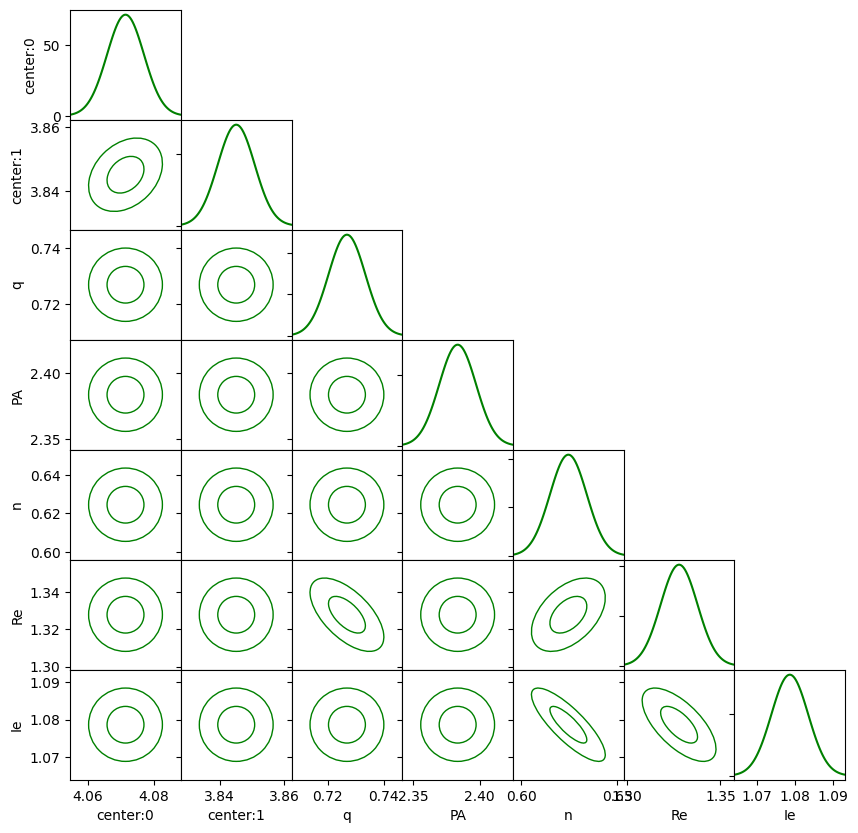

In [40]:
# Plot the uncertainty matrix

# While the scale of the uncertainty may not be meaningful if the image variance is not accurate, we
# can still see how the covariance of the parameters plays out in a given fit.
fig, ax = ap.plots.covariance_matrix(
    result.covariance_matrix.detach().cpu().numpy(),
    model2.parameters.vector_values().detach().cpu().numpy(),
    model2.parameters.vector_names(),
)
plt.show()

# OIII nebula

In [49]:
OIII_nebula = np.asarray(OIII_nebula, dtype=np.float64)

In [50]:
target = ap.image.Target_Image(
    data = OIII_nebula,
    pixelscale = 0.168, # Every target image needs to know it's pixelscale in arcsec/pixel
    zeropoint = 27, # optionally, you can give a zeropoint to tell AstroPhot what the pixel flux units are
    variance = np.ones(OII_nebula.shape)/1e3, # set the variance for this image (in general it should be more accurate than this)
)

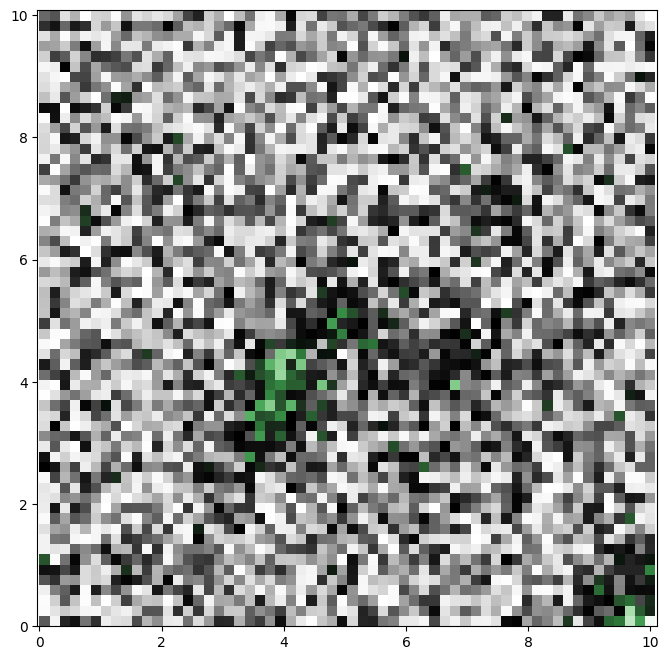

In [51]:
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target)
plt.show()

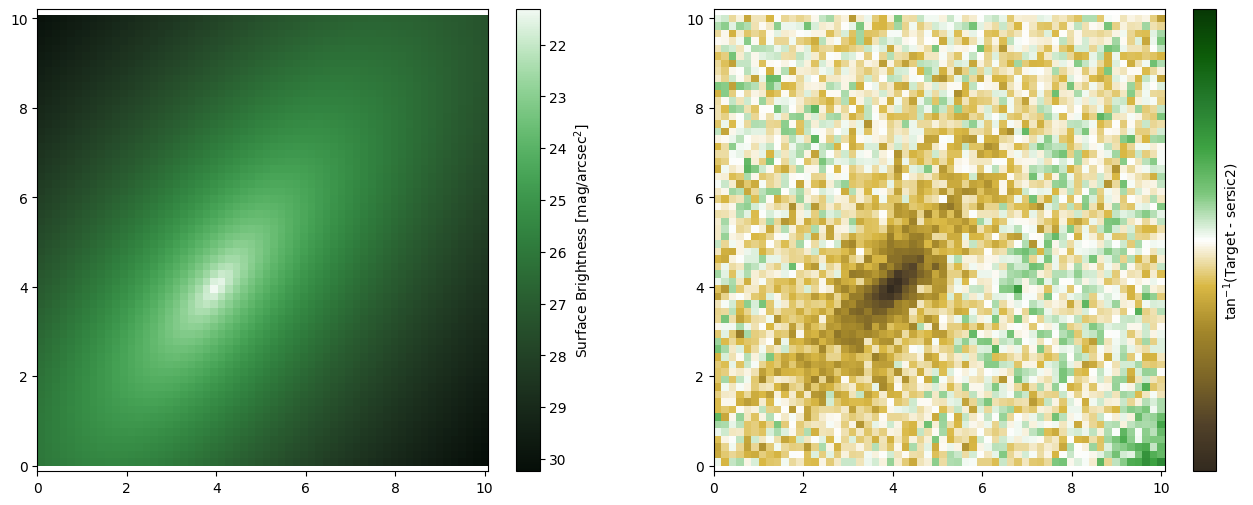

In [53]:
psf_OIII = ap.image.PSF_Image(data=fits.getdata('../../output/psf_for_pypher/SUBARU_NB0973_PSFEx_psf.fits').astype(np.float64), pixelscale = 0.168)
model2 = ap.models.AstroPhot_Model(
    name = "sersic2", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    parameters = {"center": [4,4], "q": 0.4, "PA": 322*np.pi/180, "n": 2, "Re": 3, "Ie": 1}, # here we set initial values for each parameter
    target = target, # every model needs a target, more on this later
    psf = psf_OIII,
)
model2.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

fig4, ax4 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig4, ax4[0], model2)
ap.plots.residual_image(fig4, ax4[1], model2)
plt.show()

In [54]:
# Now that the model has been set up with a target and initialized with parameter values, it is time to fit the image
result = ap.fit.LM(model2, verbose = 1).fit()

# See that we use ap.fit.LM, this is the Levenberg-Marquardt Chi^2 minimization method, it is the recommended technique
# for most least-squares problems. However, there are situations in which different optimizers may be more desireable
# so the ap.fit package includes a few options to pick from. The various fitting methods will be described in a
# different tutorial.
print("Fit message:",result.message) # the fitter will return a message about its convergence

Chi^2: 110.79655822981158, L: 1.0
Chi^2: 47.24771519674136, L: 0.3333333333333333
Chi^2: 40.60661911262681, L: 0.1111111111111111
Chi^2: 40.01319488249615, L: 0.037037037037037035
Chi^2: 39.90364195539072, L: 0.012345679012345678
Chi^2: 39.79750069505495, L: 1.693508780843029e-05
Chi^2: 39.77880691218797, L: 6.969171937625634e-08
Chi^2: 39.7729520120194, L: 7.743524375139593e-09
Chi^2: 39.77094591520165, L: 2.581174791713198e-09
Chi^2: 39.77024215333144, L: 1e-09
Chi^2: 39.769990911753496, L: 1e-09
Final Chi^2: 39.769900753259144, L: 1e-09. Converged: success
Fit message: success


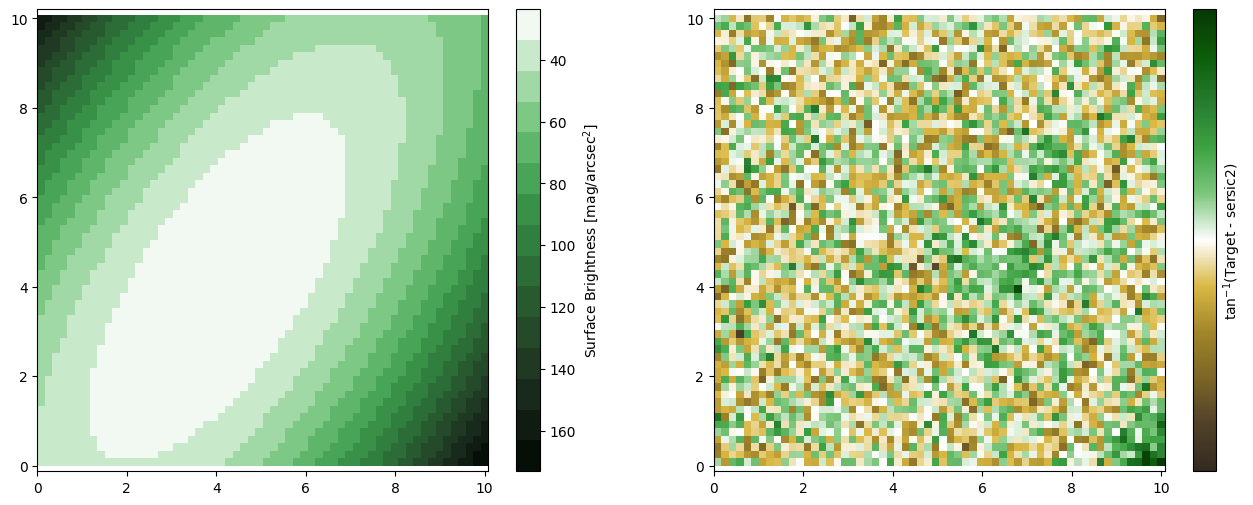

In [55]:
# we now plot the fitted model and the image residuals
fig5, ax5 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig5, ax5[0], model2, cmap_levels=15)
ap.plots.residual_image(fig5, ax5[1], model2)
plt.show()

In [56]:
result.update_uncertainty()
print(model2)

sersic2:
center: [4.065353523120641, 3.978620757325108] +- 0.1 [arcsec]
q: 0.4033627931474214 +- 0.03 [b/a], limits: (0.0, 1.0)
PA: 2.555428650343444 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
n: 0.5030201736378375 +- 0.05 [none], limits: (0.36, 8.0)
Re: 1.225858402749912 [arcsec], limits: (0.0, None)
Ie: 1.0555092330915683 [log10(flux/arcsec^2)]


In [57]:
#total luminosity of the OIII nebula
model2.total_flux()*10**(6-(27-8.9)/2.5) #microJy

tensor(3.6003, dtype=torch.float64)

# Contour masked measurements

In [8]:
OII_nebula_masked = np.ma.array(OII_nebula, mask=OII_nebula_mask==0)
OIII_nebula_masked = np.ma.array(OIII_nebula, mask=OIII_nebula_mask==0)

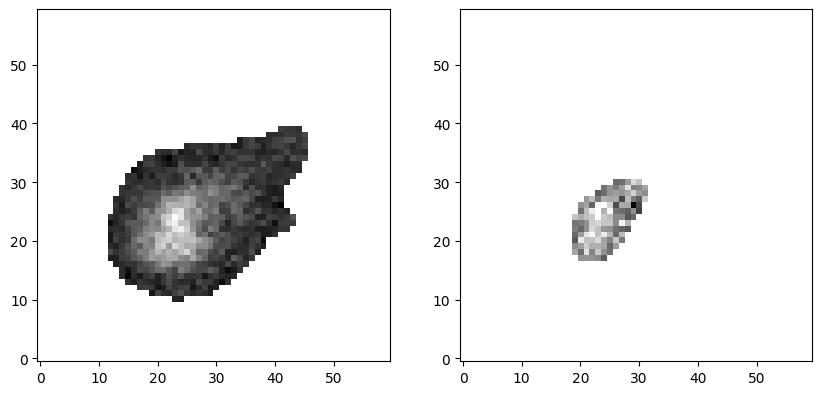

In [9]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].imshow(OII_nebula_masked, cmap='gray', origin='lower')
ax[1].imshow(OIII_nebula_masked, cmap='gray', origin='lower')

In [11]:
OII_nebula_masked.sum(), OIII_nebula_masked.sum()

(150.55582, 45.73396)

In [17]:
zeropoint = 27
OII_nebula_mag = -2.5*np.log10(OII_nebula_masked.sum()) + zeropoint
OIII_nebula_mag = -2.5*np.log10(OIII_nebula_masked.sum()) + zeropoint
OII_flux = 10**(6-(OII_nebula_mag-8.9)/2.5) #microJy
OIII_flux = 10**(6-(OIII_nebula_mag-8.9)/2.5) #microJy

In [10]:
OII_flux, OIII_flux

NameError: name 'OII_flux' is not defined

# Convert into luminosity

In [19]:
# OII_flux = 8.7081
# OIII_flux = 3.6003 #measured by Sersic model
OII_filter_path = '/home/lupengjun/OII_emitter/data/filter/SUBARU/Subaru_HSC.NB0718_filter.dat'
OIII_filter_path = '/home/lupengjun/OII_emitter/data/filter/SUBARU/Subaru_HSC.NB0973_filter.dat'

In [20]:
def int_filter_curve(file):
    '''
    Read the filter curve file and return the integral of the filter curve.
    '''
    data = np.loadtxt(file, unpack=True) #wavelength in angstrom
    frequencies = 3e18/data[0] #Hz
    return np.trapz(data[1][::-1], frequencies[::-1])


In [4]:
import numpy as np
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cos = FlatLambdaCDM(70 * u.km / u.s / u.Mpc, Om0 = 0.3,)
z = 0.924
lum_dis = cos.luminosity_distance(z).to(u.cm).value

In [23]:
OII_lum = OII_flux*1e-6*1e-23*int_filter_curve(OII_filter_path)*4*np.pi*lum_dis**2
OIII_lum = OIII_flux*1e-6*1e-23*int_filter_curve(OIII_filter_path)*4*np.pi*lum_dis**2
OII_lum, OIII_lum #erg/s

(2.132584814229505e+42, 3.4549632485576986e+41)

# X-ray upper limit

In [5]:
det_limit = 1.9 * 1e-16 #erg/s/cm^2 ref:https://arxiv.org/pdf/0903.2062.pdf
up_lum = det_limit*4*np.pi*lum_dis**2*(1+0.924)**(1.8-2) #erg/s after K correction
up_lum, np.log10(up_lum)

(7.163017836895576e+41, 41.855096032612714)

# Nebula Extent

In [24]:
#thickness of the radial shell
thickness = 1.8 #arcsec
#extent of the nebula
extent_OII = 3.8 #arcsec OII
extent_OIII = 2.8 #arcsec OIII

In [26]:
thickness_kpc = cos.angular_diameter_distance(z).to(u.kpc).value*thickness/206265 #kpc
extent_OII_kpc = cos.angular_diameter_distance(z).to(u.kpc).value*extent_OII/206265 #kpc
extent_OIII_kpc = cos.angular_diameter_distance(z).to(u.kpc).value*extent_OIII/206265 #kpc

In [27]:
thickness_kpc, extent_OII_kpc, extent_OIII_kpc

(14.127752367241413, 29.82525499750965, 21.97650368237553)